# Reassigned spectrogram

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from reassigned_spectrogram import sine_sum_signal, chirp_signal, continuous_signal, nelson_reassigned, plt_results

In [2]:
total_time = 200 #[sec]
dt = 0.01 #[sec]
time = np.arange(0,total_time, dt)

# choose signal
signal_ = sine_sum_signal(time, 3, 2, dt)
signal_ = chirp_signal(time, 1, 10, dt)


In [3]:
w_ = 5
fft_len_ = 30 #need to be at lest twice as long
overlap_ = 0.8
lim_amp = 1
F_S, Z_reassigned, CIF_1, LGD_1, freq, time_new = nelson_reassigned(signal_, w_, fft_len_, overlap_, 
                                                                                    0, 20, lim_amp)

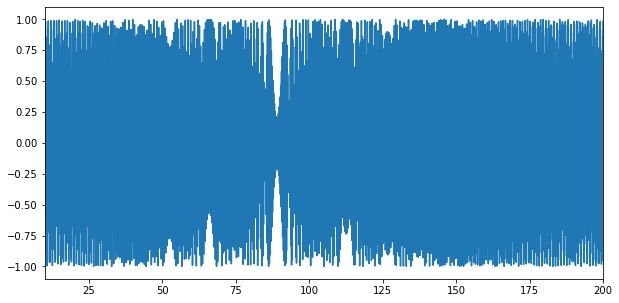

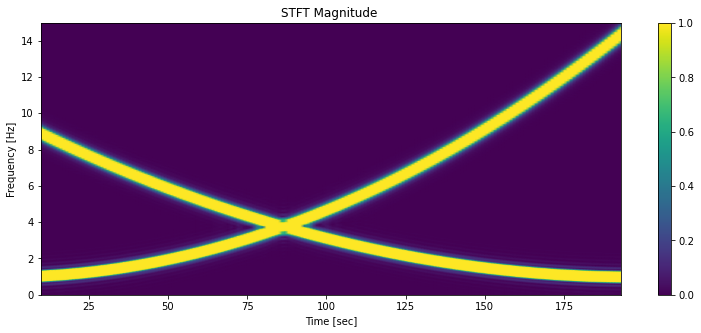

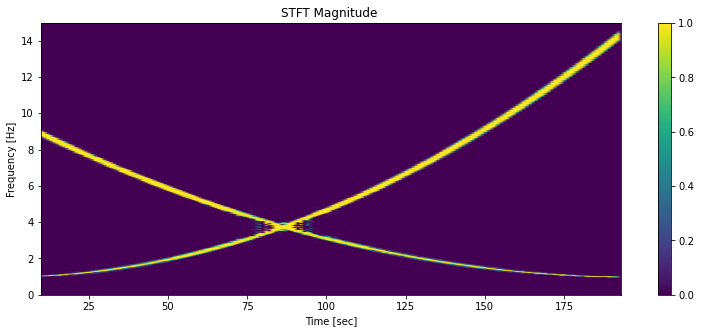

In [4]:
tmin = 10
tmax = 200
fmin = 0
fmax = 15
amp = 1
plt_results(signal_, F_S, Z_reassigned, freq, time, time_new, tmin, tmax, fmin, fmax, amp)